# Model Building and Evaluation

- Load the engineered features and split into training and testing datasets
- Search for the best parameters for the RandomForestClassifier
- Display the results of the fitted classifier
- Export the classifier for use elsewhere

---
# Code
## Import Necessary Tools and Libraries

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

ImportError: cannot import name 'joblib'

## Import Data
Import the features list that we exported in the previous notebook.

In [2]:
def get_features(path='engineered_features.csv'):
    """Gets and formats the engineered features from a CSV file.
    
    Args:
        path (string): The path of the CSV file.
        
    Returns:
        A dictionary with the features list and the labels list for the features.
    """
    data = pd.read_csv(path)    
    column_names = list(data)    
    
    FEATURES = ['red','green','blue','nir','swir1','swir2', 
                'NDVI',
                'NDVI_coeff_var',
                'PNDVI',
                'NBR',
                'NBR2',
                'NDWI_2',
                'SCI',
                'CVI',
                'CCCI',
                'bs','pv','npv'
               ]
    
    LABEL = ["LandUse"]
    
    features = data[FEATURES]
    labels = data[LABEL]
    return {'features': features, 'labels': labels}

## Split the Features
Split the given features and labels into training and testing sets.

In [3]:
def split_features(feature_set):
    """Splits the features and labels into training and test sets.
    
    Args:
        feature_set (dict): A dictionary of the features list and the labels. Needs a features and labels key.
    
    Returns:
        A dictionary of the training and testing sets.
    """
    features = feature_set['features']
    labels = feature_set['labels']
    
    X_train, X_test, y_train, y_test = train_test_split(
        features.values, labels.values.reshape(len(features))
    )
    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

## Search Functions
Functions for running a `GridSearchCV` and `RandomizedSearchCV` with specific search parameters over a `RandomForestClassifier`.

In [4]:
def grid_search(feature_set):
    """Performs a grid search over a RandomForestClassifier.
    
    Args:
        feature_set (dict): The split feature set to run the search with. Needs a X_train and y_train key.
    
    Returns:
        The best estimated RandomForestClassifier object.
    """
    X_train = feature_set['X_train']
    y_train = feature_set['y_train']
    
    rf = RandomForestClassifier(random_state = 42)
    
    search_params = {'criterion': ['gini', 'entropy'],
                     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     'min_samples_leaf': [1, 2, 4],
                     'min_samples_split': [2, 5, 10],
                     'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
                    }

    grid_search = GridSearchCV(estimator=rf,
                               param_grid=search_params, 
                               cv=3,
                               n_jobs=-1,
                               verbose=0
                              )
    
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def random_search(feature_set, n_iter):
    """Performs a grid search over a RandomForestClassifier.
    
    Args:
        feature_set (dict): The split feature set to run the search with. Needs a X_train and y_train key.
        n_iter (int): The number of iterations to search over.
    
    Returns:
        The best estimated RandomForestClassifier object.
    """
    X_train = feature_set['X_train']
    y_train = feature_set['y_train']
    
    rf = RandomForestClassifier(random_state = 42)
    
    search_params = {'criterion': ['gini', 'entropy'],
                     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     'min_samples_leaf': [1, 2, 4],
                     'min_samples_split': [2, 5, 10],
                     'n_estimators': [100, 190, 280, 370, 460, 550, 640, 730, 820, 910, 1000]
                    }

    random_search = RandomizedSearchCV(estimator=rf,
                                       param_distributions=search_params,
                                       n_iter=n_iter,
                                       cv=3,
                                       n_jobs=-1,
                                       verbose=0
                                      )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

## Display
### Importances Plot
This will display the important features as determined by the classifier.

In [5]:
def importances_plot(rf, X):
    """Plots the important features of a RandomForestClassifier.
    
    Args:
        rf (RandomForestClassifier): The classifier object to plot the feature importances for.
        X: The values of the features used.

    Citiation:
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    """
    FEATURES = ['red','green','blue','nir','swir1','swir2', 
                'NDVI',
                'NDVI_coeff_var',
                'PNDVI',
                'NBR',
                'NBR2',
                'NDWI_2',
                'SCI',
                'CVI',
                'CCCI',
                'bs','pv','npv'
               ]
    
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]),
            importances[indices],
            color="r",
            yerr=std[indices],
            align="center"
           )
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. Feature %d (%s): %f" % (f+1, indices[f], FEATURES[indices[f]], importances[indices[f]]))

### Print Scores
We will display the mean accuracy and F1 scores for the classifier as tested against our test sets.

In [6]:
def print_scores(rf, feature_set, y_pred):
    """Prints the mean accuracy and F1 scores
    
    Args:
        rf (RandomForestClassifier): The fitted classifier.
        feature_set (dict): The dictionary with the testing data. Should have X_test and y_test keys.
        y_pred: The results of a prediction with y_test data.
    """
    X_test = feature_set['X_test']
    y_test = feature_set['y_test']
    
    mean_accuracy = rf.score(X_test, y_test)

    print("The mean accuracy of the model: %f" % mean_accuracy)
    
    labels=["Forest","Prairie","Summercrops","Naturalgrassland", "Misc"]
    labels.sort()


    f1_result = f1_score(y_test, y_pred, labels=labels, average=None)
    print("The F1 scores of the model:")
    for f in range(len(labels)):
        print('\t%s: %f' % (labels[f], f1_result[f]))

### Plot a Confusion Matrix
We will plot a confusion matrix which will give us an intuitive visualization of the classifier's performance.

In [7]:
class ConfusionMatrix:
    """A ConfusionMatrix object for displaying confusion matrices.
    
    Attributes:
        cnf_matrix: A calculated confusion matrix from the input variables.
        classes: The list of classes to plot.
    """
    def __init__(self, y_test, y_pred, classes):
        """Initializes the object with the given parameters.
        
        Args:
            y_test: The true test labels.
            y_pred: The predicted test labels.
            classes: A list of the unique labels in the data.
        """
        self.cnf_matrix = self.compute_confusion_matrix(y_test, y_pred)
        classes.sort()
        self.classes = classes
    
    def plot_confusion_matrix(self, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        """Plots a confusion matrix.
        
        Args:
            normalize: Indicator for whether the matrix should be normalized or not.
            title: The title for the confusion matrix.
            cmap: The cmap that the confusion matrix will use for coloring.
            
        Returns:
            The plotted confusion matrix.
        
        Citiation:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        ---------
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        cm = self.cnf_matrix
        classes = self.classes
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        return plt.show()

    def compute_confusion_matrix(self, y_test, y_pred):
        """Computes the confusion matrix.
        
        Args:
            y_test: The true test labels.
            y_pred: The predicted test labels.
            
        Returns:
            A computed confusion matrix.
        """
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)
        return cnf_matrix

## Export Model
A function to export the model.

In [8]:
def export_rf(model, path=None):
    """Exports a RandomForestClassifier.
    
    Args:
        model (RandomForestClassifier): The RandomForestClassifier to export.
        path (string): An optional path to export the model to.
    """
    if(path is None):
        time = datetime.datetime.now().strftime("%Y%m%d%H_%M")
        path = "./classifiers/models/random_forest_{creation_time}.model".format(creation_time = time)
        
    joblib.dump(rf, path)
    print('Model saved as: %s' % path)

---

# Results

## Import Data

In [9]:
feature_set = get_features()
features = feature_set['features']
labels = feature_set['labels']

In [10]:
ndvi_coeff_var = feature_set['features']['NDVI_coeff_var']

## Split Data into Training and Testing Sets

In [11]:
feature_set = split_features(feature_set)
feature_set

{'X_test': array([[715., 714., 354., ...,  16.,  61.,  19.],
        [850., 705., 398., ...,  14.,  48.,  34.],
        [567., 706., 308., ...,  14.,  78.,   2.],
        ...,
        [645., 663., 403., ...,   6.,  60.,  30.],
        [547., 658., 387., ...,   9.,  77.,   9.],
        [781., 766., 381., ...,   8.,  65.,  24.]]),
 'X_train': array([[654., 735., 452., ...,   2.,  56.,  40.],
        [659., 773., 413., ...,   8.,  73.,  15.],
        [589., 774., 343., ...,  17.,  80.,   0.],
        ...,
        [758., 721., 414., ...,   6.,  58.,  32.],
        [621., 687., 341., ...,  10.,  73.,  13.],
        [765., 692., 398., ...,  13.,  66.,  15.]]),
 'y_test': array(['Prairie', 'Summercrops', 'Naturalgrassland', 'Misc',
        'Naturalgrassland', 'Summercrops', 'Summercrops',
        'Naturalgrassland', 'Naturalgrassland', 'Summercrops',
        'Naturalgrassland', 'Misc', 'Prairie', 'Naturalgrassland',
        'Prairie', 'Summercrops', 'Summercrops', 'Naturalgrassland',
        

## Grid Search
Very slow (typically takes 1h 20m), and the results are about the same as a randomized search. You can uncomment to use it for yourself.

In [12]:
#rf = grid_search(feature_set)
#rf

## Random Search
Faster than Grid Search (takes about 2m for 50 iterations)

In [13]:
rf = random_search(feature_set, 100)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=640, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## Show Important Features

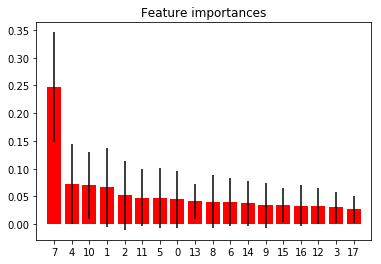

Feature ranking:
1. Feature 7 (NDVI_coeff_var): 0.247345
2. Feature 4 (swir1): 0.073099
3. Feature 10 (NBR2): 0.070139
4. Feature 1 (green): 0.066232
5. Feature 2 (blue): 0.052126
6. Feature 11 (NDWI_2): 0.047934
7. Feature 5 (swir2): 0.047238
8. Feature 0 (red): 0.044805
9. Feature 13 (CVI): 0.041045
10. Feature 8 (PNDVI): 0.040615
11. Feature 6 (NDVI): 0.040113
12. Feature 14 (CCCI): 0.037198
13. Feature 9 (NBR): 0.034427
14. Feature 15 (bs): 0.034157
15. Feature 16 (pv): 0.033251
16. Feature 12 (SCI): 0.032977
17. Feature 3 (nir): 0.030660
18. Feature 17 (npv): 0.026640


In [14]:
importances_plot(rf, features.values)

## Print Scores
The mean accuracy show us the fraction of correct predictions.

The F1 score shows us the weighted harmonic mean of precision and recall. 

Precision is $\frac{true\_positives}{true\_positives + false\_positives}$ 

Recall is $\frac{true\_positives}{true\_positives + false\_negatives}$

In [15]:
y_pred = rf.predict(feature_set['X_test'])

print_scores(rf, feature_set, y_pred)

The mean accuracy of the model: 0.698113
The F1 scores of the model:
	Forest: 0.666667
	Misc: 0.500000
	Naturalgrassland: 0.847059
	Prairie: 0.222222
	Summercrops: 0.673684


## Show Confusion Matrix

Confusion matrix, without normalization
[[ 2  0  0  0  1]
 [ 1  2  0  0  3]
 [ 0  0 36  0  7]
 [ 0  0  0  2 13]
 [ 0  0  6  1 32]]


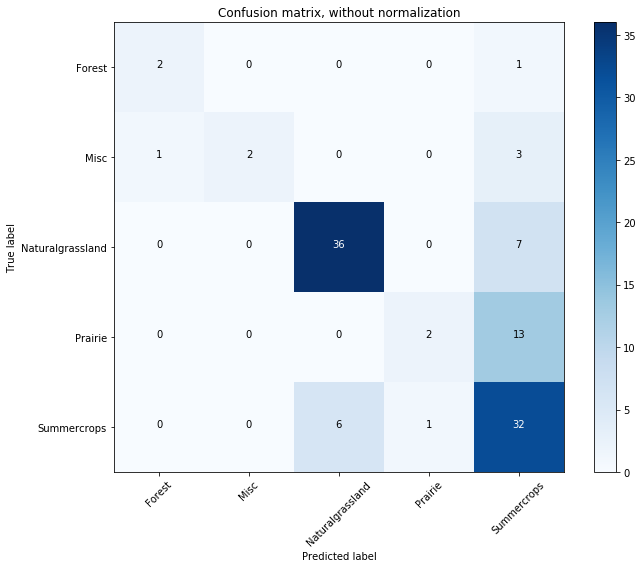

Normalized confusion matrix
[[0.67 0.   0.   0.   0.33]
 [0.17 0.33 0.   0.   0.5 ]
 [0.   0.   0.84 0.   0.16]
 [0.   0.   0.   0.13 0.87]
 [0.   0.   0.15 0.03 0.82]]


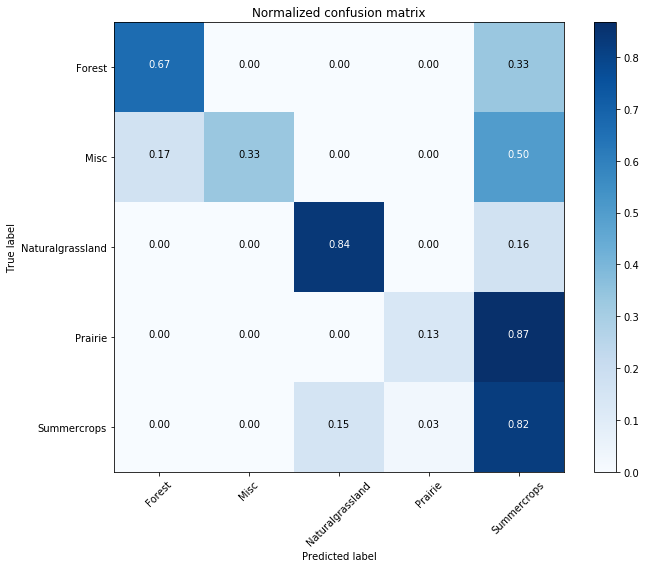

In [16]:
classes = ['Forest',
           'Misc',
           'Naturalgrassland',
           'Prairie',
           'Summercrops'
          ]

cm = ConfusionMatrix(feature_set['y_test'], y_pred, classes)

plt.figure(figsize=(10, 8))
cm.plot_confusion_matrix(title='Confusion matrix, without normalization')

plt.figure(figsize=(10, 8))
cm.plot_confusion_matrix(normalize=True, title='Normalized confusion matrix')

---
# Export Model for Later Use

We will export the model as a binary file. This will allow us to use the model we've generated for classification of new data elsewhere.

In [17]:
export_rf(rf)

Model saved as: ./classifiers/models/random_forest_2019030521_02.model
